In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Ruta de ficheros CSV a procesar
ruta_trabajo="/content/gdrive/MyDrive/sochedi2025/"

In [3]:
import pandas as pd

# Ruta al archivo (ajusta con la ubicación en tu Drive)
ruta = "/content/gdrive/MyDrive/sochedi2025/dataset_grades_anonymized.csv"

# Leer el dataset
df = pd.read_csv(ruta)

# Filtrar solo los estudiantes con datos completos en pre_test, post_test y nps
df_filtrado = df[df['pre_test'].notna() & df['post_test'].notna()] # & df['nps'].notna()

# Revisar tamaño del nuevo dataset
print("Número de estudiantes en el dataset filtrado:", df_filtrado.shape[0])

# Ver primeras filas para comprobar
df_filtrado.head()



Número de estudiantes en el dataset filtrado: 238


,sexo,edad,avance_malla,nota_final,condicion_final,pre_test,post_test
0,masculino,45,73,6.9,Aprobado,2.0,29.0
1,masculino,46,71,6.4,Aprobado,18.0,20.0
15,femenino,50,73,6.9,Aprobado,1.0,5.0
16,masculino,18,71,5.9,Aprobado,19.0,21.0
43,masculino,47,75,4.4,Aprobado,10.0,7.0


In [4]:
# === Tabla descriptiva de variables sociodemográficas ===

# 1. Distribución de sexo
sexo_tabla = df_filtrado['sexo'].value_counts().reset_index()
sexo_tabla.columns = ['Sexo', 'Frecuencia']
sexo_tabla['Porcentaje'] = (sexo_tabla['Frecuencia'] / sexo_tabla['Frecuencia'].sum() * 100).round(1)

# 2. Estadísticos de edad
edad_tabla = df_filtrado['edad'].describe()[['count','mean','std','min','25%','50%','75%','max']].round(1)
edad_tabla = edad_tabla.to_frame().rename(columns={'edad':'Edad'})

# 3. Estadísticos de avance_malla
avance_malla_tabla = df_filtrado['avance_malla'].describe()[['count','mean','std','min','25%','50%','75%','max']].round(1)
avance_malla_tabla = avance_malla_tabla.to_frame().rename(columns={'avance_malla':'Avance de malla'})

# Mostrar resultados
print("=== Distribución por sexo ===")
print(sexo_tabla)
print("\n=== Estadísticos de edad ===")
print(edad_tabla)
print("\n=== Estadísticos de Avande de Malla ===")
print(avance_malla_tabla)

=== Distribución por sexo ===
        Sexo  Frecuencia  Porcentaje
0  masculino         171        71.8
1   femenino          67        28.2

=== Estadísticos de edad ===
        Edad
count  238.0
mean    36.4
std      7.9
min     18.0
25%     31.0
50%     37.0
75%     41.8
max     59.0

=== Estadísticos de Avande de Malla ===
       Avance de malla
count            238.0
mean              36.3
std               23.2
min                0.0
25%               20.0
50%               20.0
75%               54.0
max               95.0


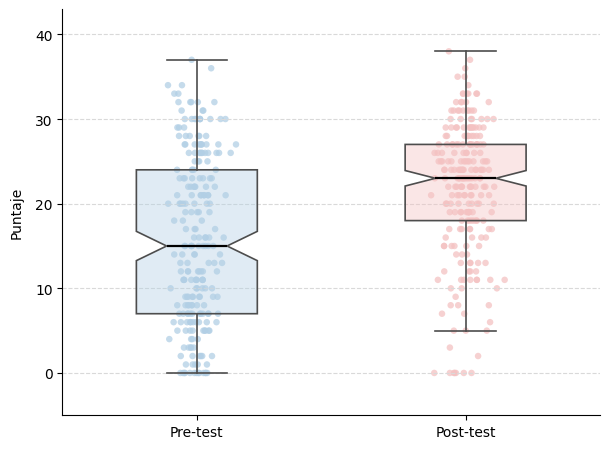

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1) Datos pareados ----------
datos_pareados = df_filtrado[['pre_test', 'post_test']].dropna().copy()
pre  = datos_pareados['pre_test'].to_numpy()
post = datos_pareados['post_test'].to_numpy()

# ---------- 2) Paleta (mantén tus colores) ----------
pal = {"Pre-test": "#b2cfe5", "Post-test": "#f4c2c2"}

# ---------- 3) Figura ----------
plt.figure(figsize=(6.2, 4.6))
ax = plt.gca()

# ---------- 4) Boxplots con "notch" y colores pastel con transparencia ----------
bp = ax.boxplot(
    [pre, post],
    positions=[1, 2],
    widths=0.45,
    notch=True,
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color='k', linewidth=1.6),
    whiskerprops=dict(color='0.3', linewidth=1.2),
    capprops=dict(color='0.3', linewidth=1.2),
    boxprops=dict(linewidth=1.2, color='0.3')
)

# Convertir hex a RGBA con alpha < 1
import matplotlib.colors as mcolors
bp['boxes'][0].set_facecolor(mcolors.to_rgba(pal['Pre-test'], alpha=0.4))
bp['boxes'][1].set_facecolor(mcolors.to_rgba(pal['Post-test'], alpha=0.4))


# ---------- 5) Puntos (jitter) ----------
rng = np.random.default_rng(42)
jitter_pre  = rng.normal(0, 0.05, size=len(pre))
jitter_post = rng.normal(0, 0.05, size=len(post))

ax.scatter(1 + jitter_pre,  pre,  s=22, alpha=0.75, color=pal['Pre-test'], edgecolor='none')
ax.scatter(2 + jitter_post, post, s=22, alpha=0.75, color=pal['Post-test'], edgecolor='none')

# ---------- 6) Medianas anotadas ----------
#med_pre  = np.median(pre)
#med_post = np.median(post)
#ax.text(1, med_pre  + 0.3,  f'Me = {med_pre:.1f}',  ha='center', va='bottom', fontsize=10)
#ax.text(2, med_post + 0.3,  f'Me = {med_post:.1f}', ha='center', va='bottom', fontsize=10)

# ---------- 7) Estética ----------
ax.set_xticks([1, 2])
ax.set_xticklabels(['Pre-test', 'Post-test'])
ax.set_ylabel('Puntaje', labelpad=8)
ymin = min(pre.min(), post.min())
ymax = max(pre.max(), post.max())
ax.set_ylim(ymin - 5, ymax + 5)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.grid(axis='y', linestyle='--', color='0.85')
ax.set_xlabel('')

plt.tight_layout()
plt.show()





In [6]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

# Filtrar solo filas con datos completos en sexo, pre y post
df_completo = df[['sexo', 'pre_test', 'post_test']].dropna()

# Separar por grupo
grupo_m = df_completo[df_completo['sexo'] == 'masculino']
grupo_f = df_completo[df_completo['sexo'] == 'femenino']

# Función para resumen estadístico
def resumen(col_m, col_f):
    return {
        'n (no perdidos)': [len(col_m), len(col_f)],
        'Mediana': [np.median(col_m), np.median(col_f)],
        'Media': [np.mean(col_m), np.mean(col_f)],
        'Q1': [np.percentile(col_m, 25), np.percentile(col_f, 25)],
        'Q3': [np.percentile(col_m, 75), np.percentile(col_f, 75)],
        'DE': [np.std(col_m, ddof=1), np.std(col_f, ddof=1)],
        'valor-p': mannwhitneyu(col_m, col_f, alternative='two-sided').pvalue
    }

# Construir tabla
tabla = {
    "Característica": [],
    "Masculino (n={})".format(len(grupo_m)): [],
    "Femenino (n={})".format(len(grupo_f)): [],
    "valor-p": []
}

# PRE-TEST
stats_pre = resumen(grupo_m['pre_test'], grupo_f['pre_test'])
tabla["Característica"].append("Puntaje (pre-test)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_pre['n (no perdidos)'][0]}")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_pre['n (no perdidos)'][1]}")
tabla["valor-p"].append(f"{stats_pre['valor-p']:.3f}")

tabla["Característica"].append("Mediana, Media (Q1, Q3)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_pre['Mediana'][0]:.1f}, {stats_pre['Media'][0]:.1f} ({stats_pre['Q1'][0]:.1f}, {stats_pre['Q3'][0]:.1f})")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_pre['Mediana'][1]:.1f}, {stats_pre['Media'][1]:.1f} ({stats_pre['Q1'][1]:.1f}, {stats_pre['Q3'][1]:.1f})")
tabla["valor-p"].append("")

tabla["Característica"].append("Desviación estándar (DE)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_pre['DE'][0]:.1f}")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_pre['DE'][1]:.1f}")
tabla["valor-p"].append("")

# POST-TEST
stats_post = resumen(grupo_m['post_test'], grupo_f['post_test'])
tabla["Característica"].append("Puntaje (post-test)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_post['n (no perdidos)'][0]}")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_post['n (no perdidos)'][1]}")
tabla["valor-p"].append(f"{stats_post['valor-p']:.3f}")

tabla["Característica"].append("Mediana, Media (Q1, Q3)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_post['Mediana'][0]:.1f}, {stats_post['Media'][0]:.1f} ({stats_post['Q1'][0]:.1f}, {stats_post['Q3'][0]:.1f})")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_post['Mediana'][1]:.1f}, {stats_post['Media'][1]:.1f} ({stats_post['Q1'][1]:.1f}, {stats_post['Q3'][1]:.1f})")
tabla["valor-p"].append("")

tabla["Característica"].append("Desviación estándar (DE)")
tabla["Masculino (n={})".format(len(grupo_m))].append(f"{stats_post['DE'][0]:.1f}")
tabla["Femenino (n={})".format(len(grupo_f))].append(f"{stats_post['DE'][1]:.1f}")
tabla["valor-p"].append("")

# Mostrar tabla
tabla_df = pd.DataFrame(tabla)
print(tabla_df.to_string(index=False))



          Característica       Masculino (n=171)         Femenino (n=67) valor-p
      Puntaje (pre-test)                     171                      67   0.007
 Mediana, Media (Q1, Q3)  16.0, 16.7 (9.0, 25.0)  11.0, 12.9 (4.5, 21.5)        
Desviación estándar (DE)                     9.7                     9.9        
     Puntaje (post-test)                     171                      67   0.051
 Mediana, Media (Q1, Q3) 24.0, 22.3 (19.0, 27.5) 22.0, 20.2 (16.0, 25.5)        
Desviación estándar (DE)                     7.9                     8.1        


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon

# Filtrar datos pareados (elimina filas con NA en pre o post)
df_pareado = df[['pre_test', 'post_test']].dropna()

# Estadísticos descriptivos
n = len(df_pareado)
media_pre = df_pareado['pre_test'].mean()
media_post = df_pareado['post_test'].mean()
mediana_pre = df_pareado['pre_test'].median()
mediana_post = df_pareado['post_test'].median()
sd_pre = df_pareado['pre_test'].std()
sd_post = df_pareado['post_test'].std()

# Prueba de Wilcoxon
v_stat, p_valor = wilcoxon(df_pareado['pre_test'], df_pareado['post_test'])

# Calcular Cliff's delta en datos pareados
diffs = df_pareado['post_test'] - df_pareado['pre_test']
n_pos = np.sum(diffs > 0)
n_neg = np.sum(diffs < 0)
cliffs_delta = (n_pos - n_neg) / n

# Bootstrap para IC95% de Cliff's delta
n_boot = 5000
boot_deltas = []
rng = np.random.default_rng(seed=123)  # semilla reproducible

for _ in range(n_boot):
    sample = rng.choice(diffs, size=n, replace=True)
    n_pos_b = np.sum(sample > 0)
    n_neg_b = np.sum(sample < 0)
    delta_b = (n_pos_b - n_neg_b) / n
    boot_deltas.append(delta_b)

boot_deltas = np.array(boot_deltas)
ci_lower, ci_upper = np.percentile(boot_deltas, [2.5, 97.5])

# Crear tabla
tabla = pd.DataFrame({
    'Test': ['Puntaje (Pre-test)', 'Puntaje (Post-test)'],
    'n': [n, n],
    'Media': [round(media_pre, 2), round(media_post, 2)],
    'Mediana': [round(mediana_pre, 2), round(mediana_post, 2)],
    'DE': [round(sd_pre, 2), round(sd_post, 2)],
    'V de Wilcoxon (valor-p)': ['', f"V = {int(v_stat)} (p = {p_valor:.2e}){'***' if p_valor < 0.001 else ''}"]
})

# Mostrar tabla
print("\nTabla. Prueba de rangos con signo de Wilcoxon pareada")
print(tabla.to_string(index=False))

# Mostrar Cliff's delta e IC95%
print(f"\nTamaño del efecto (Cliff's delta): {cliffs_delta:.3f}")
print(f"IC 95% bootstrap: [{ci_lower:.3f}, {ci_upper:.3f}]")

# Interpretación (Romano et al., 2006)
abs_delta = abs(cliffs_delta)
if abs_delta < 0.147:
    interpretacion = "efecto despreciable"
elif abs_delta < 0.33:
    interpretacion = "efecto pequeño"
elif abs_delta < 0.474:
    interpretacion = "efecto mediano"
else:
    interpretacion = "efecto grande"

print(f"Interpretación según Romano et al. (2006): {interpretacion}")





Tabla. Prueba de rangos con signo de Wilcoxon pareada
               Test   n  Media  Mediana   DE    V de Wilcoxon (valor-p)
 Puntaje (Pre-test) 238  15.65     15.0 9.87                           
Puntaje (Post-test) 238  21.68     23.0 7.97 V = 3557 (p = 5.12e-18)***

Tamaño del efecto (Cliff's delta): 0.429
IC 95% bootstrap: [0.319, 0.534]
Interpretación según Romano et al. (2006): efecto mediano


In [ ]:
import pandas as pd
from scipy.stats import spearmanr

# Selección de variables de interés
variables = df[['post_test', 'nota_final']].dropna()

# Lista de nombres para mostrar en la tabla
nombres = {
    'post_test': 'Puntaje Taller (post_test)',
    'nota_final': 'Nota Final',
}

# Crear tabla vacía
resultados = []

# Calcular correlaciones por pares
cols = list(variables.columns)
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        var1, var2 = cols[i], cols[j]
        rho, pval = spearmanr(variables[var1], variables[var2])
        resultados.append({
            "Par de variables": f"{nombres[var1]} ↔ {nombres[var2]}",
            "ρ de Spearman": round(rho, 3),
            "Valor-p": f"{pval:.3e}"  # notación científica si es pequeño
        })

# Convertir en DataFrame tipo tabla APA
tabla_spearman = pd.DataFrame(resultados)

# Mostrar tabla
print("\nTabla. Correlaciones de Spearman entre puntajes del taller, desempeño académico y percepción estudiantil")
print(tabla_spearman.to_string(index=False))


Tabla. Correlaciones de Spearman entre puntajes del taller, desempeño académico y percepción estudiantil
                       Par de variables  ρ de Spearman   Valor-p
Puntaje Taller (post_test) ↔ Nota Final          0.002 9.726e-01
